## 导入模块

In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style()
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 数据获取

### 数据来源

数据来源于[小米应用商店](http://app.mi.com/)的App信息。共28个类别的APP，每个类别不到2000个App，总App数据量约5万个，获取App的名字，类别，描述，url等信息，存储为json文件，在data/文件夹目录下。  

### 获取方式
初步打算是用[scrapy](https://github.com/scrapy/scrapy)框架爬取数据，但中间涉及到splash处理动态页面，未能提取pagination的信息，目前只能获取每个类别APP的第一页App list，只能获取约4000个App信息，暂时还未能找到原因，可能是scrapy的抽象层次比较高，隐藏了好多细节，对爬虫新手来说不太容易debug，但scrapy提供的框架还是非常有启发性的。  
![scrapy frame](http://scrapy-chs.readthedocs.io/zh_CN/0.24/_images/scrapy_architecture.png)  
由于时间有限，就采取了爬取速度比较慢(相比与，scrapy是异步爬取，的确是快，怪不得都要设置wait参数，对server要nice)但比较直接的方式，`requests + beautifulsoup`。主要仿照scrapy的框架，爬虫设计有一下这些模块。  

主要思路是，从[Root URL](http://app.mi.com/)，爬取每个类别首页的[URL](http://app.mi.com/category/5)，然后获取每个类别所有页面的[URL](http://app.mi.com/category/5#page=66)，然后从这些页面获取所有App细节的[URL](http://app.mi.com/detail/120956)，然后解析这些页面的数据，存储之。
- [spider_main](https://github.com/lyltj2010/miapp/blob/master/spider/spider_main.py)，是中央调度器，负责启动程序，调用下载器，解析器、存储器。
- [html_downloader](https://github.com/lyltj2010/miapp/blob/master/spider/html_downloader.py)，负责根据指定的url，用requests或PhantomJS(需要渲染javascript的页面)发送请求，返回response。
- [html_parser](https://github.com/lyltj2010/miapp/blob/master/spider/html_parser.py)，解析器，负责根据给定的response，解析出下一步需要爬取的url或需要存储的信息。
- [json_outputer](https://github.com/lyltj2010/miapp/blob/master/spider/json_outputer.py)，存储器，负责接收html parser解析的数据，并存储为json文件。  

这是程序运行时候的截图。  
![spider](spider.png)

In [2]:
# get all json format data
apps = []
for file in os.listdir(os.getcwd() + '/data'):
    if file.endswith('.json'):
        apps.append(file)
        
df = pd.DataFrame()
for app in apps:
    df1 = pd.read_json('data/'+app)
    df = df.append(df1)
    
df = df.drop_duplicates(subset='url')
df = df.reset_index(drop=True)

In [3]:
df.tail(3)

,category,comments_num,company,detail,name,rating,root,size,support,updated_at,url,version
42113,时尚购物,( 479次评分 ),北京快乐时代科技发展有限公司,趣分期是深受中国大学生喜爱的分期购物商城。帮助中国3000万大学生树立正确的消费观、信用观，...,趣分期,"[star1-hover, star1-6]",▪ （基于网络的）粗略位置▪ 精准的(GPS)位置▪ 查看网络状态▪ 查看 Wi-Fi 状态...,6.59 M,手机,2016-05-20,http://app.mi.com/detail/74516,1.7.0
42114,时尚购物,( 0次评分 ),曾超,购省心网是一个精选优质商品的导购省钱网站，专注全网独家优惠折扣，帮您在网络海量商品中挑选出平...,购省心,"[star1-hover, star1-0]",▪ （基于网络的）粗略位置▪ 精准的(GPS)位置▪ 查看网络状态▪ 查看 Wi-Fi 状态...,7.03 M,手机,2016-05-20,http://app.mi.com/detail/67450,2.4
42115,时尚购物,( 0次评分 ),四川国立创投科技有限公司,“看了么”是一款基于LBS地理定位，结合威客、大数据营销的移动互联网应用。\r对于用户来说，...,看了么,"[star1-hover, star1-0]",▪ （基于网络的）粗略位置▪ 精准的(GPS)位置▪ 查看网络状态▪ 查看 Wi-Fi 状态...,12.7 M,手机,2016-05-20,http://app.mi.com/detail/339044,1.0.6


# 数据清理

由于数据获取是没有经过pipeline处理，所以这里需要对数据进行一下清理。

### 提取评论数
提取( 4590次评分 )里面的整数。

In [4]:
def get_comments_num(string):
    n = re.findall('\d+',string)[0]
    return int(n)

df.comments_num = df.comments_num.map(get_comments_num)

In [5]:
df.comments_num[:3]

0     0
1    78
2     0
Name: comments_num, dtype: int64

In [6]:
df.comments_num.argmax()

17667

In [7]:
print df.iloc[17667]['name']

微博


### 提取软件size
从 `6.59 M`里提取float6.59。

In [8]:
def get_size(string):
    size = re.findall('\d+\.*\d*',string)[0]
    return float(size)

df['size'] = df['size'].map(get_size)

In [9]:
df['size'][:3]

0     7.88
1    16.78
2     6.16
Name: size, dtype: float64

### 更新时间
把2016-06-30转化为时间，便于group。

In [10]:
df.updated_at = df.updated_at.map(pd.to_datetime)

In [11]:
df.updated_at[:3]

0   2016-06-30
1   2016-06-30
2   2016-06-30
Name: updated_at, dtype: datetime64[ns]

### 版本

In [12]:
def get_version(version):
    v = re.findall('\d+\.*\d{0,2}',version)[0]
    return float(v)

In [13]:
# drop rows with invalid version
index = ~ (df.version.str.contains('\d+\.*\d{0,2}'))
df.drop(df[index].index,inplace=True)

In [14]:
df.version = df.version.map(get_version)

In [15]:
df.version[:3]

0    1.0
1    2.3
2    2.1
Name: version, dtype: float64

### 评分
由于元数据的评分是用星号多少表示的，需要提取里面的数字，得到1-10的得分，比如[u'star1-hover', u'star1-10']是10分。

In [16]:
def get_rating(rating):
    r = re.findall('(\d{1,2})$',rating[-1])[0] # like [u'star1-hover', u'star1-10']
    return int(r)

In [17]:
df.rating = df.rating.map(get_rating)

In [18]:
df.rating[:3]

0    0
1    4
2    0
Name: rating, dtype: int64

## 数据分析

In [19]:
df.head(1)

,category,comments_num,company,detail,name,rating,root,size,support,updated_at,url,version
0,金融理财,0,中航生意贷,平台介绍：\r中航生意贷—全球首创航空金融互联网交易平台，打造航空业与融资租赁领域理财第一品...,中航生意贷,0,▪ （基于网络的）粗略位置▪ 精准的(GPS)位置▪ 查看网络状态▪ 查看 Wi-Fi 状态...,7.88,手机,2016-06-30,http://app.mi.com/detail/422230,1.0


### 精品推荐

我们数据里有app的评分数据，所谓精品就是评论人很多而且评分很高，评论多说明这个app受众很大，而且用户比较活跃，同时用户体验也比较好。这里给出前100的App，给app控们一个参考，url都给你了，快拿走吧！  

In [20]:
index_full = (df.rating == 10)
index_popular = df.comments_num >= 6000
top_list = index_full & index_popular

In [50]:
df[top_list][['name','category','comments_num','rating','url']].sort_values(by='comments_num',ascending=False)[:10]

,name,category,comments_num,rating,url
40794,手机淘宝,时尚购物,260468,10,http://app.mi.com/detail/1023
2189,WPS Office,效率办公,171674,10,http://app.mi.com/detail/14322
34637,小米路由器,实用工具,163138,10,http://app.mi.com/detail/53711
35979,美图秀秀,摄影摄像,148775,10,http://app.mi.com/detail/1326
6087,猿题库,学习教育,96139,10,http://app.mi.com/detail/61201
41350,百度糯米-美食电影,时尚购物,94615,10,http://app.mi.com/detail/497
18233,派派同城交友聊天,聊天社交,92035,10,http://app.mi.com/detail/19174
32475,中华万年历日历,居家生活,89964,10,http://app.mi.com/detail/69
27009,虾米音乐,影音视听,83637,10,http://app.mi.com/detail/31250
25681,超级玛丽,跑酷闯关,82607,10,http://app.mi.com/detail/9436


In [30]:
d = df[top_list][['name','category','comments_num','rating','url']].sort_values(by='comments_num',ascending=False)

In [49]:
d[d.category==u'时尚购物']

,name,category,comments_num,rating,url
40794,手机淘宝,时尚购物,260468,10,http://app.mi.com/detail/1023
41350,百度糯米-美食电影,时尚购物,94615,10,http://app.mi.com/detail/497
41471,返利,时尚购物,12479,10,http://app.mi.com/detail/4928
41531,抹茶美妆,时尚购物,9700,10,http://app.mi.com/detail/50989
40692,生日管家,时尚购物,7946,10,http://app.mi.com/detail/6934
41620,一淘,时尚购物,7701,10,http://app.mi.com/detail/360


### APP发布热图

不同的类别，根据其更新的时间，我们可以查看其发布更新的密度，绘制heatmap，密度较大的类别的app市场比较活跃，如果做app开发，可以一眼看出哪里机会大！    

影音视听,娱乐消遣,效率办公,医疗健康,金融理财,聊天社交,学习教育,新闻资讯,实用工具,网游RPG,时尚购物,儿童益智,休闲创意,旅行交通,居家生活,赛车体育,图书阅读,动作枪战,摄影摄像,跑酷闯关,模拟经营,体育运动,飞行空战,棋牌桌游,战争策略,格斗快打,塔防迷宫.

In [51]:
import calmap

In [52]:
df['num'] = 1

In [53]:
def plot_heat(df,cat=None):
    # plot heat map by category
    data = df.copy()
    if cat != None:
        data = data[data.category==cat]
    grouped = data.groupby('updated_at').agg({
            'num' : 'count'
        })
    events = grouped.num
    calmap.calendarplot(events['2016':], monthticks=1, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], linewidth=0.1,
                    fig_kws=dict(figsize=(12,5)));   

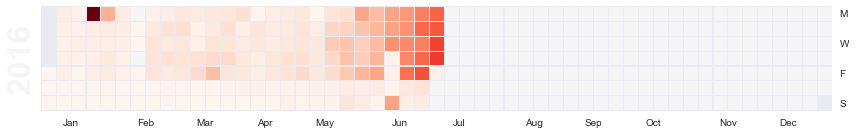

In [59]:
plot_heat(df) # 所有app

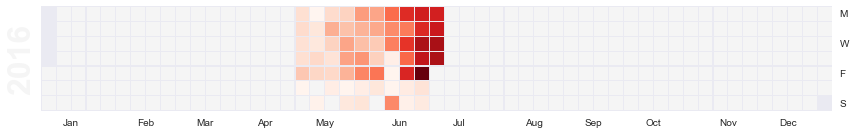

In [61]:
plot_heat(df,u'金融理财')

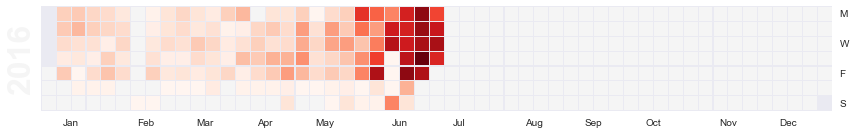

In [62]:
plot_heat(df,u'医疗健康')

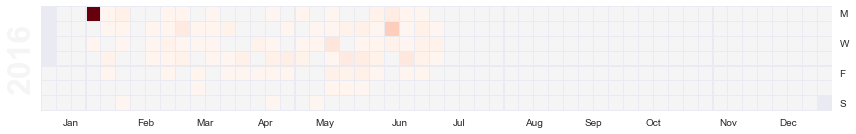

In [66]:
plot_heat(df,u'棋牌桌游')

### 分词
[结巴分词](https://github.com/fxsjy/jieba).  
目的是用app的描述进行分类，需要对描述进行分词，这样能提高准确率。jieba分词是一个比较好用的分词开源库。

In [68]:
import jieba

In [69]:
print df.loc[1].detail
s = df.loc[1].detail

- 合作机构：宜信(宜人贷)、平安普惠、闪银、51信用卡管家、手机贷、拍拍贷、蚂蚁聚宝、陆金所、玖富、翼龙贷、点融网、有利网、你我贷、铜板街等。


In [70]:
seg_list= jieba.lcut(s,cut_all=False) # 精确模式

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sf/vzv4v23j7v91ckykt3l9r14c0000gn/T/jieba.cache
Loading model cost 0.465 seconds.
Prefix dict has been built succesfully.


In [72]:
# filter out punctutation
pun = [u'【',u'】',u'（',u'）',u'，',u'。',u'？',u'',u'；',u'、',u'：',u'-',u'%',u'(',u')',u':',u'.',u':',u'￥',u'$',u'~']
new_seg = filter(lambda x: x not in pun, seg_list)

In [74]:
for i in new_seg:
    print i,

  合作 机构 宜信 宜人 贷 平安 普惠 闪银 51 信用卡 管家 手机 贷 拍拍 贷 蚂蚁 聚宝 陆金 所 玖富 翼龙贷 点融 网 有利 网 你 我 贷 铜板 街 等


In [75]:
# 带权重
import jieba.analyse
for x, w in jieba.analyse.extract_tags(df.loc[2].detail, topK=10, withWeight=True):
    print('%s %s' % (x, w))

金融 0.492253439
app 0.373586484466
领金 0.373586484466
高管 0.373586484466
交流平台 0.344072059191
一站式 0.314751132984
实名 0.295563324859
社交 0.292418214678
十几万 0.291436458546
精准 0.287791555305


- [参考1](http://yphuang.github.io/blog/2016/04/15/Working-with-Text-Data-using-sklearn/)  
- [参考2](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)  
- [参考3](https://github.com/bambooom/play-Shakespeare/blob/master/Play-Shakespeare-in-Python.ipynb)  
- [参考4](http://cloga.info/2014/01/19/sklearn_text_feature_extraction/)

### 文本分类

In [76]:
df.head(1)

,category,comments_num,company,detail,name,rating,root,size,support,updated_at,url,version,num
0,金融理财,0,中航生意贷,平台介绍：\r中航生意贷—全球首创航空金融互联网交易平台，打造航空业与融资租赁领域理财第一品...,中航生意贷,0,▪ （基于网络的）粗略位置▪ 精准的(GPS)位置▪ 查看网络状态▪ 查看 Wi-Fi 状态...,7.88,手机,2016-06-30,http://app.mi.com/detail/422230,1.0,1


In [77]:
from sklearn import cross_validation
X = df.detail # features
y = df.category # target

In [78]:
# 用jieba分词
def get_words(string):
    s = []
    # for word, weight in jieba.analyse.extract_tags(string, topK=10,withWeight=True):
    for word in jieba.lcut(string,cut_all=False):
        s.append(word)
    pun = [u'【',u'】',u'（',u'）',u'，',u',',u'。',u'？',u'！',u'!',u'；',u'、',u'：',u'-',u'%',u'(',u')',u':',u'.',u':',u'￥',u'$',u'~']
    new_s = filter(lambda x: x not in pun, s)
    new_string = ' '.join(new_s)
    return new_string

In [79]:
print df.loc[10].detail

掌上石油是原油行业最权威的手机软件,提供原油资讯，最新的原油动态、财经日历、原油供应的价格行情等原油信息服务。此外还提供各大交易所贵金属价格行情，还有模拟交易大赛等你赢奖金。


In [80]:
print get_words(df.loc[10].detail)

掌上 石油 是 原油 行业 最 权威 的 手机软件 提供 原油 资讯 最新 的 原油 动态 财经 日历 原油 供应 的 价格行情 等 原油 信息 服务 此外 还 提供 各大 交易所 贵金属 价格行情 还有 模拟 交易 大赛 等 你 赢 奖金


把app的描述进行分词，然后进行训练，比直接训练的效果有大于10%的提升，还是比较明显的。

In [81]:
df.detail = df.detail.apply(get_words)
X = df.detail # features
y = df.category # target

In [82]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,train_size=0.75)

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [84]:
# 计算词频
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
X_train_counts.shape

(31581, 123382)

In [85]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(31581, 123382)

In [86]:
# multinomial variant in naive bayes 进行分类
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [87]:
# 对 test data 处理为 tfidf, 进行 predict
X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(10528, 123382)

In [88]:
y_predicted = clf.predict(X_test_tfidf)

In [89]:
np.mean(y_predicted == y_test)

0.63592325227963531

In [91]:
# 换linear SVM 准确率有所提升
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(X_train_tfidf, y_train)

In [92]:
y_predicted_svm = sgd.predict(X_test_tfidf)

In [93]:
np.mean(y_predicted_svm == y_test)

0.69832826747720367

### 可视化
受[竹子](https://github.com/bambooom/play-Shakespeare)启发，用word cloud可视化，感觉挺炫酷。  
[word_cloud](https://github.com/amueller/word_cloud)  
[word cloud live版](https://www.jasondavies.com/wordcloud/)

In [94]:
from wordcloud import WordCloud, ImageColorGenerator
from scipy.misc import imread

In [95]:
df.detail[0:2]

0    平台 介绍 \r 中航 生意 贷 — 全球 首创 航空 金融 互联网 交易平台 打造 航空业...
1    为什么 要 使用 融 360 下述 内容 不 吹牛 \r 1   解决 贷款 难题 \r 特...
Name: detail, dtype: object

In [96]:
#随机取15000个app，因为数据量太大了
lucky = np.random.randint(0,len(df),15000)
full_text = pd.Series(df.detail[lucky]).str.cat(sep=' ')

In [97]:
import jieba.analyse
text = jieba.analyse.extract_tags(full_text, topK=5000, withWeight=True)
# 类似 text = [(u'搞笑',3),(u'不要',2),(u'坏人',3),(u'好人',1),(u'哈哈',3),(u'快点',4)]

### 支持中文

默认英文可以很好地可视化，但遇到中文有点困难，word_cloud的作者也吐槽说中文分词太难了。。。那就用jieba先分词后再喂给word_cloud。  

同时还需要安装支持中文的字体，比如msyh.ttf，然后提供font_path给WordCloud函数。
- [issue参考1](https://github.com/amueller/word_cloud/issues/59)
- [issue参考2](https://github.com/amueller/word_cloud/issues/12)
- [issue参考3](https://github.com/amueller/word_cloud/issues/101)

In [106]:
# -*- coding: utf-8 -*-
base_image = imread("app.jpg")
wc = WordCloud(background_color="white", stopwords=stop,font_path='/Users/yongle/Library/Fonts/msyh.ttf', max_words=5000, mask=base_image,max_font_size=40, random_state=42)
wc.generate_from_frequencies(text)
image_colors = ImageColorGenerator(base_image)

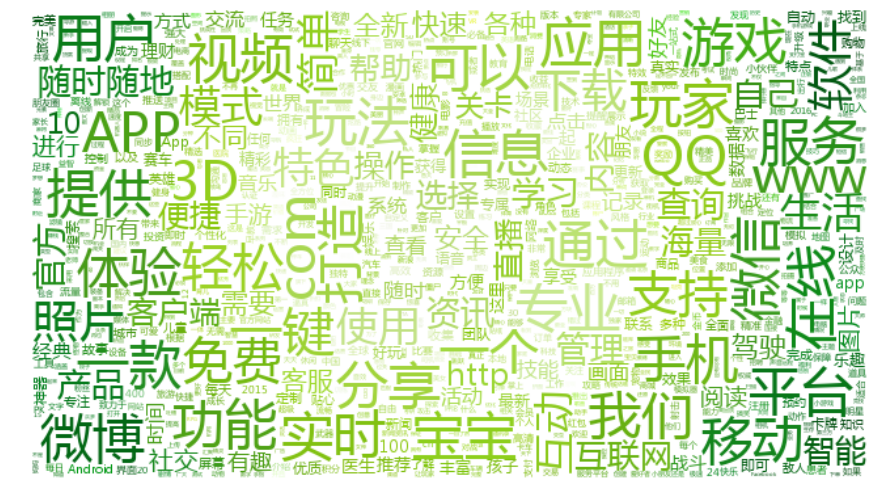

In [107]:
plt.figure(figsize = (15,30))
plt.imshow(wc.recolor(color_func=image_colors),aspect='equal')
plt.axis("off")
plt.show()